# Tema: Atención

 **10. (Medio-Avanzado) Atención**: En un problema de apredizaje Seq-2-Seq, una red recurrente con mecanismos atencionales será siempre más efectiva que una arquitectura recurrente encoder-decoder sin atención.

fuente: https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb

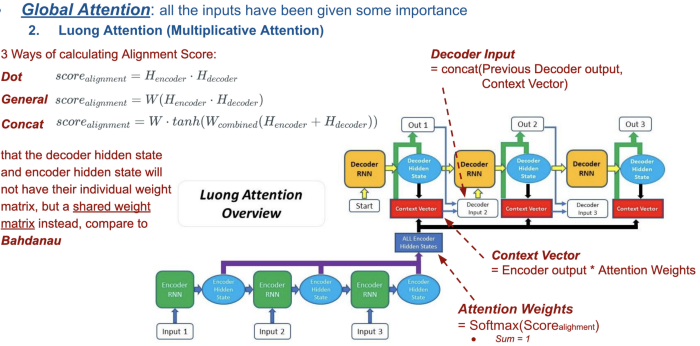

En esta implementación se calculará el score via producto punto

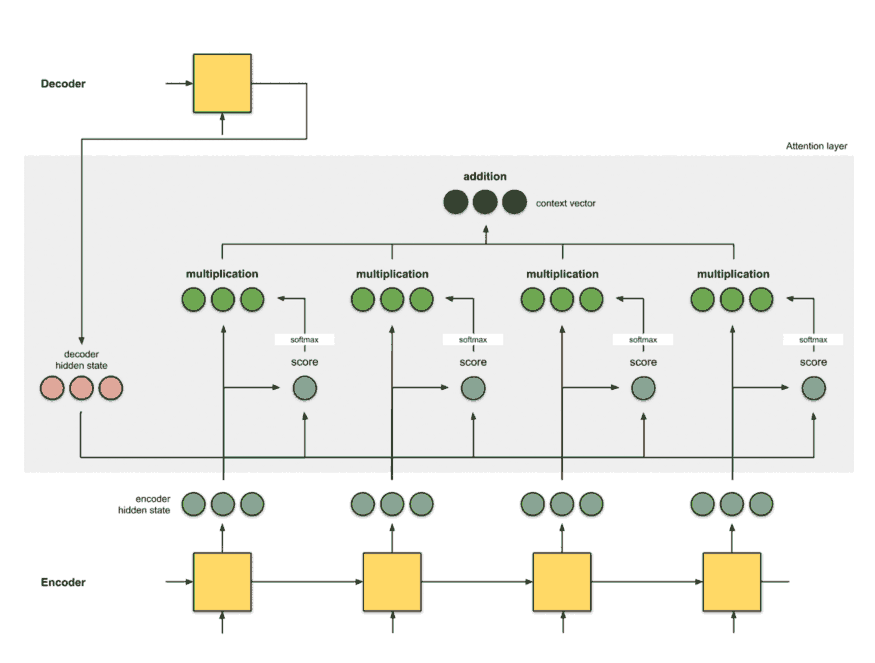

# Liberias

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle as pkl
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Flatten, Activation, dot, GRU, Attention
from keras.optimizers import Adam
#from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import pydot as pyd
from keras.utils.vis_utils import plot_model, model_to_dot
keras.utils.vis_utils.pydot = pyd


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Import necessary modules
from sklearn.metrics import mean_squared_error

# Keras specific
import keras
from keras.models import Sequential
from keras.layers import Dense

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from keras.callbacks import History,EarlyStopping
from tensorflow.keras.regularizers import L1, L2, L1L2


import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
import pydot



#help(mp_pose.Pose)


from numpy.random import seed
import random as python_random
import random

import warnings
warnings.filterwarnings("ignore")

seed(48)
python_random.seed(48)
tf.random.set_seed(48)

#Cambiar el formato de las fechas a dd-mm-aa
import datetime
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot

from keras.layers import LSTM
from datetime import date
from datetime import datetime, timedelta

from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional

from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Flatten, Activation, dot
from keras.utils.vis_utils import plot_model, model_to_dot

# Predicción de acciones

In [ ]:
pip install yfinance

     |████████████████████████████████| 6.3 MB 40.3 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=4c3e2df3636e9094868e44c6ea63ce8fb063054a8bf4c5e9b7cb57d771b7c8f0
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import yfinance as yf

In [ ]:
df=yf.download("CFIETFGE.SN",start="2017-01-01", end= "2021-08-09") #, end= "2021-07-29") 
df= df["Open"]

[*********************100%***********************]  1 of 1 completed


In [ ]:
df

Date
2019-07-25    1122.900024
2019-07-26    1145.150024
2019-07-29    1142.099976
2019-07-30    1140.000000
2019-07-31    1147.400024
                 ...     
2021-08-02    1728.199951
2021-08-03    1750.500000
2021-08-04    1757.199951
2021-08-05    1765.000000
2021-08-06    1787.500000
Name: Open, Length: 498, dtype: float64

In [ ]:
j = 0
data = []
Traces = {
1 :'trace0',
2: 'trace1',
3: 'trace2'
}

Traces[0] = go.Scatter(
         x = df.index ,
         y = df.values,
         mode = 'lines',
         name = "Datos"
     )
data.append(Traces[j]) 


layout = go.Layout(
      xaxis=dict(title='Fechas'),
      yaxis=dict(title='Valor'),
      title=('Precio acción en $CLP'))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [ ]:
dias_pred= 3
considerando= 15

In [ ]:
def preprocesamiento(data, n_input, n_output, n_step):

  for i in range(0, data.shape[0]-n_input-n_output, n_step):
      salto= data.shape[0]-i-n_output
      x = data[salto-n_input:salto].reshape(1,n_input)
      y = data[salto: salto+n_output].reshape(1,n_output)
      if i == 0:
        X = x
        Y = y
      else:
        X = np.vstack((X,x))
        Y = np.vstack((Y,y))
  return X.reshape(X.shape[0], X.shape[1], 1), Y

In [ ]:
X, Y= preprocesamiento(np.array(df).reshape(df.shape[0]) ,considerando,dias_pred,1)

Split

In [ ]:
X_train, Y_train= X[:int(X.shape[0]*0.85)],Y[:int(X.shape[0]*0.85)]
X_val, Y_val=X[int(X.shape[0]*0.85):],Y[int(X.shape[0]*0.85):]

In [ ]:
print("----Entrenamiento---")
print(X_train.shape)
print(Y_train.shape)
print("----Validacion---")
print(X_val.shape)
print(Y_val.shape)

----Entrenamiento---
(408, 15, 1)
(408, 3)
----Validacion---
(72, 15, 1)
(72, 3)


Estandar Scaler

In [ ]:
mu= np.mean(X_train)
sigma= np.std(X_train)
X_train= (X_train-mu)/sigma
X_val= (X_val-mu)/sigma
Y_train= (Y_train-mu)/sigma
Y_val= (Y_val-mu)/sigma

## Encoder Decoder 

In [ ]:
def enc_dec(X_train,Y_train,X_val,Y_val):
  # define model
  model = Sequential()
  #enconder
  model.add(LSTM(200, activation='relu',name="encoder", input_shape=(X_train.shape[1], 1)))
  model.add(RepeatVector(dias_pred))

  #decoder
  model.add(LSTM(200, activation='relu', name="decoder",return_sequences=True))
  model.add(TimeDistributed(Dense(1)))

  model.compile(optimizer='adam', loss='mse')
  my_callbacks = [History(), EarlyStopping(patience=3, monitor="val_loss",restore_best_weights=True)]
  history= model.fit(X_train, Y_train, epochs=300, verbose=1, batch_size=16,validation_data=(X_val,Y_val), callbacks= my_callbacks)
  x_input = X_val.reshape((X_val.shape[0], considerando, 1))
  yhat = model.predict(x_input, verbose=0)
  return yhat, history, model

In [ ]:
y_enc_dec, history,model= enc_dec(X_train,Y_train,X_val,Y_val) 

Epoch 1/300
26/26 [==============================] - 7s 117ms/step - loss: 0.8600 - val_loss: 1.1038
Epoch 2/300
26/26 [==============================] - 2s 93ms/step - loss: 0.3762 - val_loss: 0.8660
Epoch 3/300
26/26 [==============================] - 2s 82ms/step - loss: 0.2091 - val_loss: 0.4769
Epoch 4/300
26/26 [==============================] - 2s 84ms/step - loss: 0.1596 - val_loss: 0.3540
Epoch 5/300
26/26 [==============================] - 2s 69ms/step - loss: 0.1113 - val_loss: 0.1162
Epoch 6/300
26/26 [==============================] - 2s 90ms/step - loss: 0.0853 - val_loss: 0.0837
Epoch 7/300
26/26 [==============================] - 2s 86ms/step - loss: 0.0792 - val_loss: 0.0752
Epoch 8/300
26/26 [==============================] - 2s 96ms/step - loss: 0.0751 - val_loss: 0.1204
Epoch 9/300
26/26 [==============================] - 2s 94ms/step - loss: 0.0760 - val_loss: 0.0611
Epoch 10/300
26/26 [==============================] - 2s 92ms/step - loss: 0.0838 - val_loss: 0.053

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (LSTM)               (None, 200)               161600    
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 3, 200)            0         
_________________________________________________________________
decoder (LSTM)               (None, 3, 200)            320800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 3, 1)              201       
Total params: 482,601
Trainable params: 482,601
Non-trainable params: 0
_________________________________________________________________


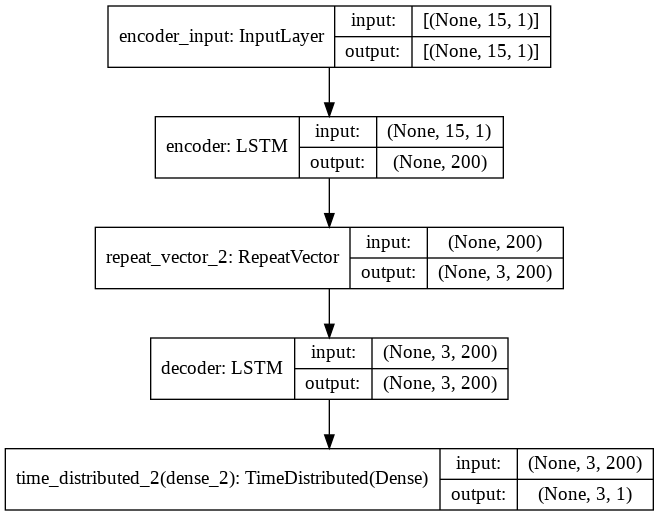

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
mean_squared_error(Y_val, y_enc_dec.reshape(Y_val.shape[0],dias_pred) )

0.04446055450280711

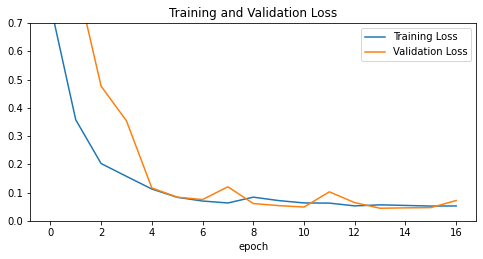

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.7])

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Con Atención de Luong

In [ ]:
def atencionLuong(X_train, Y_train, X_test,Y_test,n_feautures=1):
  input_train = Input(shape=(X_train.shape[1], n_feautures))
  output_train = Input(shape=(Y_train.shape[1],n_feautures))

  encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(200, activation='relu',name="encoder",return_state=True, return_sequences=True)(input_train)

  #print(encoder_stack_h)
  #print(encoder_last_h)
  #print(encoder_last_c)

  #encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
  #encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)
  decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
  #print(decoder_input)

  decoder_stack_h = LSTM(200, activation='relu',name="decoder",
                        return_state=False, return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])

  attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2]) #similaridad
  attention = Activation('softmax')(attention) #hago que sume 1
  context = dot([attention, encoder_stack_h], axes=[2,1]) # combina con el encoder
  #context = BatchNormalization(momentum=0.6)(context)
  decoder_combined_context = concatenate([context, decoder_stack_h]) #concateno con la salidad
  out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
  model = Model(inputs=input_train, outputs=out)
  model.compile(optimizer='adam', loss='mse',metrics=["mse"])

  my_callbacks = [History(), EarlyStopping(patience=3, monitor="val_loss",restore_best_weights=True)]
  history=model.fit(X_train, Y_train, epochs=300, verbose=1,batch_size=16, validation_data=(X_test,Y_test), callbacks= my_callbacks)
  x_input = X_test.reshape((X_test.shape[0], X_train.shape[1], 1))
  y_pred = model.predict(x_input, verbose=0)
  return y_pred,history,model


In [ ]:
y_att, history,model_a= atencionLuong(X_train,Y_train,X_val,Y_val) 

Epoch 1/300
26/26 [==============================] - 7s 108ms/step - loss: 0.5399 - mse: 0.5399 - val_loss: 0.1634 - val_mse: 0.1634
Epoch 2/300
26/26 [==============================] - 2s 73ms/step - loss: 0.1288 - mse: 0.1288 - val_loss: 0.0563 - val_mse: 0.0563
Epoch 3/300
26/26 [==============================] - 2s 59ms/step - loss: 0.0726 - mse: 0.0726 - val_loss: 0.0442 - val_mse: 0.0442
Epoch 4/300
26/26 [==============================] - 2s 65ms/step - loss: 0.0644 - mse: 0.0644 - val_loss: 0.1300 - val_mse: 0.1300
Epoch 5/300
26/26 [==============================] - 2s 62ms/step - loss: 0.0611 - mse: 0.0611 - val_loss: 0.0665 - val_mse: 0.0665
Epoch 6/300
26/26 [==============================] - 2s 68ms/step - loss: 0.0561 - mse: 0.0561 - val_loss: 0.0512 - val_mse: 0.0512


In [ ]:
model_a.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 15, 1)]      0                                            
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 15, 200), (N 161600      input_3[0][0]                    
__________________________________________________________________________________________________
repeat_vector_3 (RepeatVector)  (None, 3, 200)       0           encoder[0][1]                    
__________________________________________________________________________________________________
decoder (LSTM)                  (None, 3, 200)       320800      repeat_vector_3[0][0]            
                                                                 encoder[0][1]              

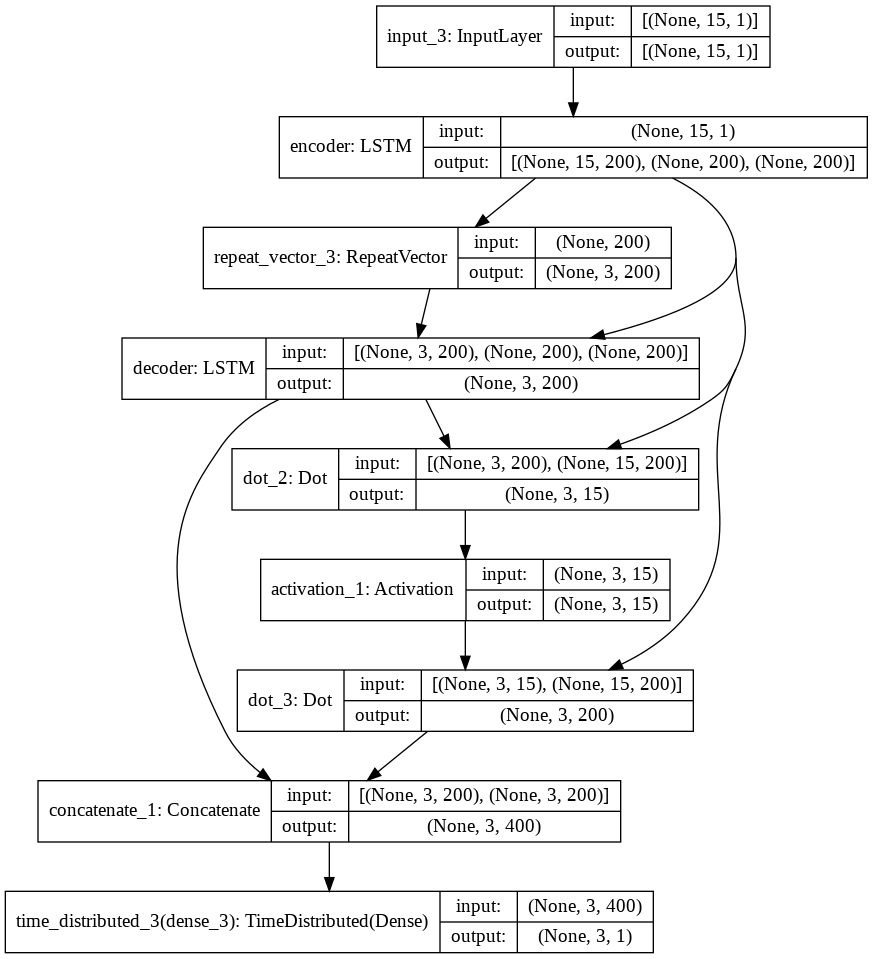

In [ ]:
plot_model(model_a, show_shapes=True, show_layer_names=True)

In [ ]:
mean_squared_error(Y_val, y_att.reshape(Y_val.shape[0],dias_pred) )

0.044184112148473266

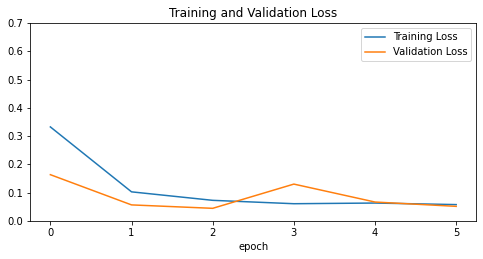

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.7])

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Comparación

In [ ]:
mse_ed=[]
epoc_ed=[]
mse_att=[]
epoc_att=[]
dias=[3,4,5,6,7,8,9,10]
considerando=15
for dias_pred in dias:
  X, Y= preprocesamiento(np.array(df).reshape(df.shape[0]) ,considerando,dias_pred,1)
  X_train, Y_train= X[:int(X.shape[0]*0.85)],Y[:int(X.shape[0]*0.85)]
  X_val, Y_val=X[int(X.shape[0]*0.85):],Y[int(X.shape[0]*0.85):] 
  mu= np.mean(X_train)
  sigma= np.std(X_train)
  X_train= (X_train-mu)/sigma
  X_val= (X_val-mu)/sigma
  Y_train= (Y_train-mu)/sigma
  Y_val= (Y_val-mu)/sigma 


  y_enc_dec, history,model= enc_dec(X_train,Y_train,X_val,Y_val) 
  mse_ed.append(mean_squared_error(Y_val, y_enc_dec.reshape(Y_val.shape[0],dias_pred) ))
  epoc_ed.append(len(history.history["loss"]))
  

  y_att, history,model_a= atencionLuong(X_train,Y_train,X_val,Y_val) 
  mse_att.append(mean_squared_error(Y_val, y_att.reshape(Y_val.shape[0],dias_pred)))
  epoc_att.append(len(history.history["loss"]))

Epoch 1/100
4/4 [==============================] - 10s 650ms/step - loss: 1.1505 - val_loss: 2.0465
Epoch 2/100
4/4 [==============================] - 0s 32ms/step - loss: 1.0992 - val_loss: 1.9770
Epoch 3/100
4/4 [==============================] - 0s 35ms/step - loss: 1.0453 - val_loss: 1.8870
Epoch 4/100
4/4 [==============================] - 0s 32ms/step - loss: 1.0298 - val_loss: 1.7604
Epoch 5/100
4/4 [==============================] - 0s 34ms/step - loss: 0.9243 - val_loss: 1.5599
Epoch 6/100
4/4 [==============================] - 0s 33ms/step - loss: 0.8264 - val_loss: 1.2375
Epoch 7/100
4/4 [==============================] - 0s 32ms/step - loss: 0.7720 - val_loss: 0.7513
Epoch 8/100
4/4 [==============================] - 0s 33ms/step - loss: 0.6099 - val_loss: 0.5198
Epoch 9/100
4/4 [==============================] - 0s 41ms/step - loss: 0.4426 - val_loss: 0.4984
Epoch 10/100
4/4 [==============================] - 0s 36ms/step - loss: 0.4458 - val_loss: 0.5328
Epoch 11/100
4/4 

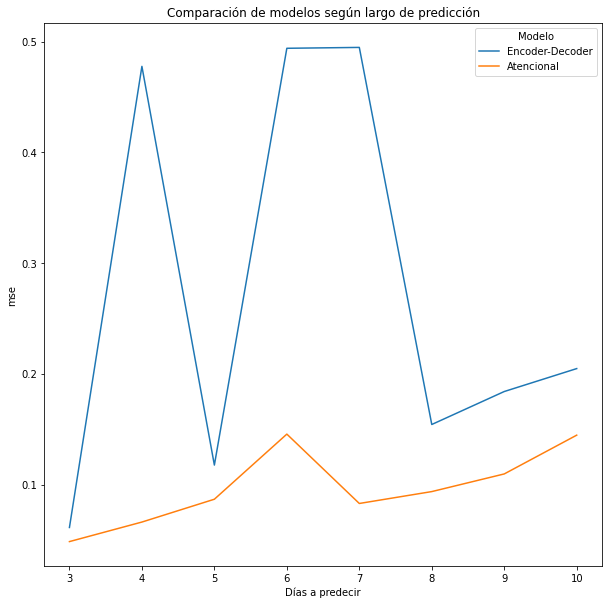

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(dias,mse_ed,dias,mse_att)
plt.legend( ["Encoder-Decoder","Atencional"] ,title= "Modelo")
plt.xlabel("Días a predecir")
plt.ylabel("mse")
plt.title("Comparación de modelos según largo de predicción")
plt.show()

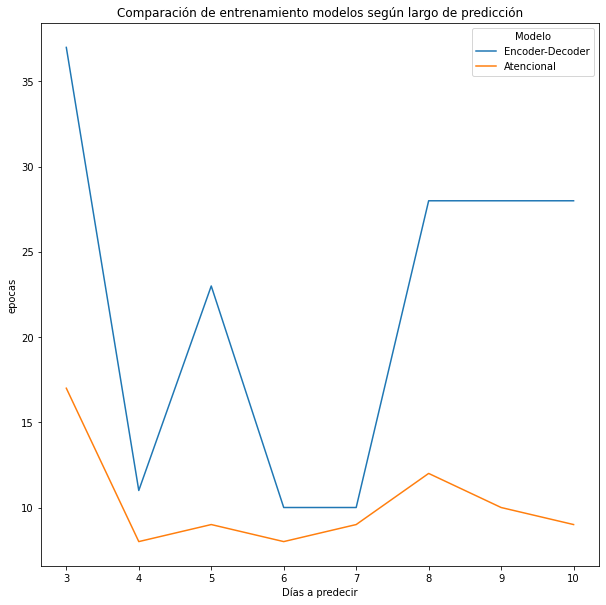

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(dias,epoc_ed,dias,epoc_att)
plt.legend( ["Encoder-Decoder","Atencional"] ,title= "Modelo")
plt.xlabel("Días a predecir")
plt.ylabel("epocas")
plt.title("Comparación de entrenamiento modelos según largo de predicción")
plt.show()

In [ ]:
0.044184112148473266*sigma+mu

1414.1018457536984

## Testeo

In [ ]:
df=yf.download("CFIETFGE.SN",start="2017-01-01")
df= df["Open"]

[*********************100%***********************]  1 of 1 completed


In [ ]:
X_train, Y_train= preprocesamiento(np.array(df) ,15,3,1)

In [ ]:
#test=np.array(df)[-15:].reshape(15,1)
test= X_train[0].reshape(15,1)

In [ ]:
test

array([[1700.        ],
       [1687.69995117],
       [1666.89001465],
       [1699.09997559],
       [1685.09997559],
       [1718.09997559],
       [1724.        ],
       [1702.30004883],
       [1734.19995117],
       [1725.        ],
       [1720.40002441],
       [1728.19995117],
       [1750.5       ],
       [1757.19995117],
       [1765.        ]])

In [ ]:
print(df.shape)
print("----Entrenamiento---")
print(X_train.shape)
print(Y_train.shape)
print(test.shape)

(500,)
----Entrenamiento---
(482, 15, 1)
(482, 3)
(15, 1)


In [ ]:
mu= np.mean(X_train)
sigma= np.std(X_train)
X_train= (X_train-mu)/sigma
X_test= (test-mu)/sigma
Y_train= (Y_train-mu)/sigma

In [ ]:
def atencionLuong(X_train, Y_train, X_test,n_feautures=1):
  input_train = Input(shape=(X_train.shape[1], n_feautures))
  output_train = Input(shape=(Y_train.shape[1],n_feautures))

  encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(200, activation='relu',name="encoder",return_state=True, return_sequences=True)(input_train)

  #print(encoder_stack_h)
  #print(encoder_last_h)
  #print(encoder_last_c)

  #encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
  #encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)
  decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
  #print(decoder_input)

  decoder_stack_h = LSTM(200, activation='relu',name="decoder",
                        return_state=False, return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])

  attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
  attention = Activation('softmax')(attention)
  context = dot([attention, encoder_stack_h], axes=[2,1])
  #context = BatchNormalization(momentum=0.6)(context)
  decoder_combined_context = concatenate([context, decoder_stack_h])
  out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
  model = Model(inputs=input_train, outputs=out)
  model.compile(optimizer='adam', loss='mse',metrics=["mse"])

  my_callbacks = [History(), EarlyStopping(patience=3, monitor="val_loss",restore_best_weights=True)]
  history=model.fit(X_train, Y_train, epochs=300, verbose=1,batch_size=16, validation_split=0.2, callbacks= my_callbacks)
  x_input = X_test.reshape((1, X_train.shape[1], 1))
  y_pred = model.predict(x_input, verbose=0)
  return y_pred,history,model

In [ ]:
y_pred ,h,m= atencionLuong(X_train, Y_train, X_test)

Epoch 1/300
25/25 [==============================] - 6s 86ms/step - loss: 0.6134 - mse: 0.6134 - val_loss: 0.2028 - val_mse: 0.2028
Epoch 2/300
25/25 [==============================] - 1s 40ms/step - loss: 0.1199 - mse: 0.1199 - val_loss: 0.0541 - val_mse: 0.0541
Epoch 3/300
25/25 [==============================] - 1s 40ms/step - loss: 0.0950 - mse: 0.0950 - val_loss: 0.0450 - val_mse: 0.0450
Epoch 4/300
25/25 [==============================] - 1s 40ms/step - loss: 0.0759 - mse: 0.0759 - val_loss: 0.0404 - val_mse: 0.0404
Epoch 5/300
25/25 [==============================] - 1s 40ms/step - loss: 0.0550 - mse: 0.0550 - val_loss: 0.0491 - val_mse: 0.0491
Epoch 6/300
25/25 [==============================] - 1s 42ms/step - loss: 0.0679 - mse: 0.0679 - val_loss: 0.0333 - val_mse: 0.0333
Epoch 7/300
25/25 [==============================] - 1s 42ms/step - loss: 0.0533 - mse: 0.0533 - val_loss: 0.1777 - val_mse: 0.1777
Epoch 8/300
25/25 [==============================] - 1s 42ms/step - loss: 0.

In [ ]:
y_pred_=y_pred*sigma + mu

In [ ]:
fechas_pred=[]
for i in range(3):
  fechas_pred.append(pd.to_datetime(df.index,format='%Y-%m-%d')[-1] + timedelta(days=i+1))

In [ ]:
j = 0
data = []
Traces = {
1 :'trace0',
2: 'trace1',
3: 'trace2'
}

Traces[0] = go.Scatter(
         x = df.index ,
         y = df.values,
         mode = 'lines',
         name = "Datos"
     )
data.append(Traces[j]) 

Traces[1] = go.Scatter(
         x = df.index[-3:],#fechas_pred,
         y = y_pred_[0].reshape(1,3)[0],
         mode = 'lines',
         name = "predicción"
     )
data.append(Traces[1]) 

layout = go.Layout(
      xaxis=dict(title='Fechas'),
      yaxis=dict(title='Valor'),
      title=('Precio acción en $CLP'))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

# Predicción del viento

In [ ]:
# hacer la conexión a Google Drive

from google.colab import drive

colab_flag = True

if (colab_flag):
    drive.mount('/content/drive',force_remount=True)



path = '/content/drive/MyDrive/ANN-2021-I/'

Mounted at /content/drive


In [ ]:
train= pd.read_csv(path+'velocidad-viento/windspeed-training.csv')
train.columns= ["Fecha","Velocidad"]
#train["Fecha"]= train.Fecha.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M'))

In [ ]:
j = 0
data = []
Traces = {
1 :'trace0',
2: 'trace1',
3: 'trace2'
}

Traces[0] = go.Scatter(
         x = train['Fecha'] ,
         y = train['Velocidad'],
         mode = 'lines',
         name = "Train"
     )
data.append(Traces[j]) 



layout = go.Layout(
      xaxis=dict(title='Fechas'),
      yaxis=dict(title='Velocidad'),
      title=('Velocidad...'))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

# Encoder-Decoder

In [ ]:
def enc_dec(X_train,Y_train,X_val,Y_val):
  # define model
  model = Sequential()
  #enconder
  model.add(LSTM(50, activation='relu',name="encoder",dropout=0.2, recurrent_dropout=0.2, activity_regularizer=tf.keras.regularizers.l1(0.01),
                 kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None), input_shape=(X_train.shape[1], 1)))
  model.add(RepeatVector(dias_pred))

  #decoder
  model.add(LSTM(50, activation='relu',dropout=0.2, recurrent_dropout=0.2,
                         kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None), name="decoder",return_sequences=True))
  model.add(TimeDistributed(Dense(1)))

  model.compile(optimizer='adam', loss='mse')
  my_callbacks = [History(), EarlyStopping(patience=3, monitor="val_loss",restore_best_weights=True)]
  history= model.fit(X_train, Y_train, epochs=100, verbose=1, batch_size=128,validation_data=(X_val,Y_val), callbacks= my_callbacks)
  x_input = X_val.reshape((X_val.shape[0], considerando, 1))
  yhat = model.predict(x_input, verbose=0)
  return yhat, history, model

## Atencion

In [ ]:
def atencionLuong(X_train, Y_train, X_test,Y_test,n_feautures=1):
  input_train = Input(shape=(X_train.shape[1], n_feautures))
  output_train = Input(shape=(Y_train.shape[1],n_feautures))

  encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(50, activation='relu',dropout=0.2, recurrent_dropout=0.2, activity_regularizer=tf.keras.regularizers.l1(0.01),
                 kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None),name="encoder",return_state=True, return_sequences=True)(input_train)

  #print(encoder_stack_h)
  #print(encoder_last_h)
  #print(encoder_last_c)

  encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
  encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)
  decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
  #print(decoder_input)

  decoder_stack_h = LSTM(50, activation='relu',name="decoder",dropout=0.2, recurrent_dropout=0.2,
                         kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None),
                        return_state=False, return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])

  attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
  attention = Activation('softmax')(attention)
  context = dot([attention, encoder_stack_h], axes=[2,1])
  context = BatchNormalization(momentum=0.6)(context)
  decoder_combined_context = concatenate([context, decoder_stack_h])
  out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
  model = Model(inputs=input_train, outputs=out)
  model.compile(optimizer='adam', loss='mse',metrics=["mse"])

  my_callbacks = [History(), EarlyStopping(patience=3, monitor="val_loss",restore_best_weights=True)]
  history=model.fit(X_train, Y_train, epochs=100, verbose=1,batch_size=128, validation_data=(X_test,Y_test), callbacks= my_callbacks)
  x_input = X_test.reshape((X_test.shape[0], X_train.shape[1], 1))
  y_pred = model.predict(x_input, verbose=0)
  return y_pred,history,model


## Comparación

In [ ]:
train.iloc[106948]

Fecha        2015-01-01 00:00
Velocidad                11.8
Name: 106948, dtype: object

In [ ]:
train.iloc[119908:]

Fecha  Velocidad
119908  2015-04-01 00:00        8.3
119909  2015-04-01 00:10        7.4
119910  2015-04-01 00:20        7.5
119911  2015-04-01 00:30        6.6
119912  2015-04-01 00:40        6.3
...                  ...        ...
123359  2015-04-24 23:10        0.5
123360  2015-04-24 23:20        0.7
123361  2015-04-24 23:30        1.3
123362  2015-04-24 23:40        2.6
123363  2015-04-24 23:50        4.2

[3456 rows x 2 columns]

In [ ]:
velocidad_2015=train.iloc[119908:]

In [ ]:
mse_ed=[]
epoc_ed=[]
mse_att=[]
epoc_att=[]
dias=[72,144,144*5,144*10]
considerando=144*5
for dias_pred in dias:
  X, Y= preprocesamiento(np.array(velocidad_2015.Velocidad).reshape(velocidad_2015.shape[0]) ,considerando,dias_pred,18)
  X_train, Y_train= X[:int(X.shape[0]*0.85)],Y[:int(X.shape[0]*0.85)]
  X_val, Y_val=X[int(X.shape[0]*0.85):],Y[int(X.shape[0]*0.85):] 
  mu= np.mean(X_train)
  sigma= np.std(X_train)
  X_train= (X_train-mu)/sigma
  X_val= (X_val-mu)/sigma
  Y_train= (Y_train-mu)/sigma
  Y_val= (Y_val-mu)/sigma 

  y_enc_dec, history,model= enc_dec(X_train,Y_train,X_val,Y_val) 
  mse_ed.append(mean_squared_error(Y_val, y_enc_dec.reshape(Y_val.shape[0],dias_pred) ))
  epoc_ed.append(len(history.history["loss"]))

  y_att, history,model_a= atencionLuong(X_train,Y_train,X_val,Y_val) 
  mse_att.append(mean_squared_error(Y_val, y_att.reshape(Y_val.shape[0],dias_pred)))
  epoc_att.append(len(history.history["loss"]))

Epoch 1/100
1/1 [==============================] - 10s 10s/step - loss: 1.0029 - val_loss: 1.0464
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 0.9951 - val_loss: 1.0462
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 0.9901 - val_loss: 1.0468
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 0.9852 - val_loss: 1.0482
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 0.9814 - val_loss: 1.0501
Epoch 1/100
1/1 [==============================] - 11s 11s/step - loss: 16.9163 - mse: 4.0135 - val_loss: 12.2932 - val_mse: 1.0378
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 14.9033 - mse: 2.1709 - val_loss: 12.0433 - val_mse: 1.0363
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 14.2202 - mse: 1.7659 - val_loss: 11.7693 - val_mse: 1.0352
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 13.7085 - mse: 1.5755 - val_loss: 11.4866 - val_mse: 1.0

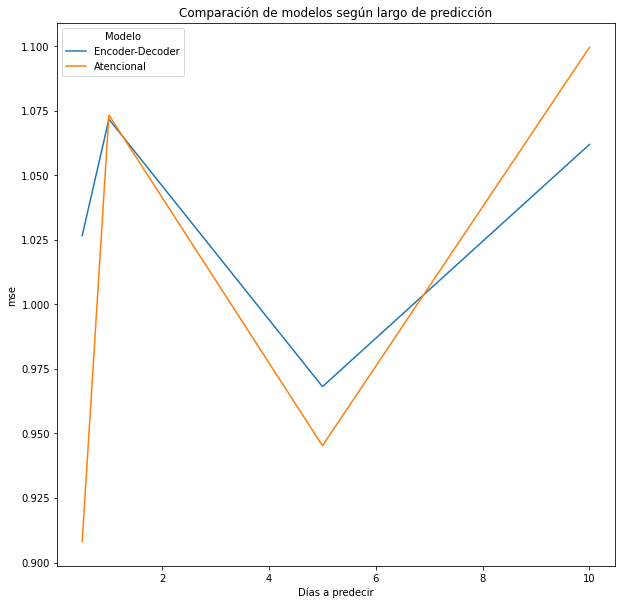

In [ ]:
dias=[0.5,1,5,10]
plt.figure(figsize=(10, 10))
plt.plot(dias,mse_ed,dias,mse_att)
plt.legend( ["Encoder-Decoder","Atencional"] ,title= "Modelo")
plt.xlabel("Días a predecir")
plt.ylabel("mse")
plt.title("Comparación de modelos según largo de predicción")
plt.show()

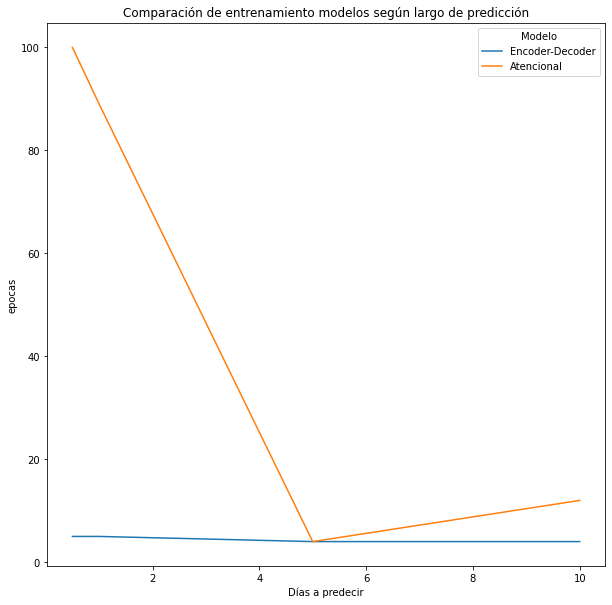

In [ ]:
dias=[0.5,1,5,10]
plt.figure(figsize=(10, 10))
plt.plot(dias,epoc_ed,dias,epoc_att)
plt.legend( ["Encoder-Decoder","Atencional"] ,title= "Modelo")
plt.xlabel("Días a predecir")
plt.ylabel("epocas")
plt.title("Comparación de entrenamiento modelos según largo de predicción")
plt.show()

# Data sintética

## Datos

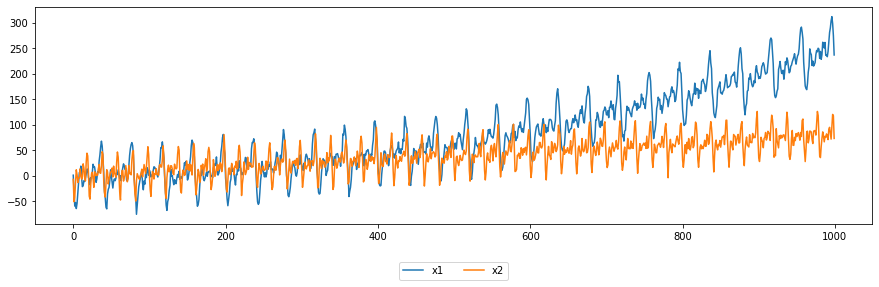

In [ ]:
n_ = 1000
t = np.linspace(0, 50*np.pi, n_)
# pattern + trend + noise
x1 = sum([20*np.sin(i*t+np.pi) for i in range(5)]) + 0.01*(t**2) + np.random.normal(0, 6, n_)
x2 = sum([15*np.sin(2*i*t+np.pi) for i in range(5)]) + 0.5*t + np.random.normal(0, 6, n_)
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x2)), x2, label='x2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

## Preprocesamiento

In [ ]:
train_ratio = 0.8
train_len = int(train_ratio * t.shape[0])
print('Largo train: ',train_len)

x_index = np.array(range(len(t)))

x1_trend_param = np.polyfit(x_index[:train_len], x1[:train_len], 2) #Ajustamos un polinomio de grado 2 en la tendencia azul
x2_trend_param = np.polyfit(x_index[:train_len], x2[:train_len], 1) #Ajustamos un polinomio de grado 1 en la tendencia naranja
print(x1_trend_param)
print(x2_trend_param)

Largo train:  800
[ 2.45567176e-04  7.33871331e-03 -2.36972834e+00]
[ 0.08078445 -0.79907114]


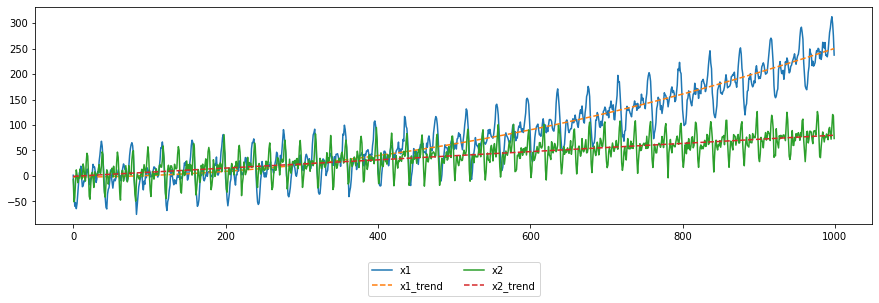

In [ ]:
#Se crean los polinomios

x1_trend = (x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2] 
x2_trend = x_index*x2_trend_param[0]+x2_trend_param[1]

#gráfica de la serie con su tendencia polinomial

plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x1_trend)), x1_trend, linestyle='--', label='x1_trend')
plt.plot(range(len(x2)), x2, label='x2')
plt.plot(range(len(x2_trend)), x2_trend, linestyle='--', label='x2_trend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)

plt.show()

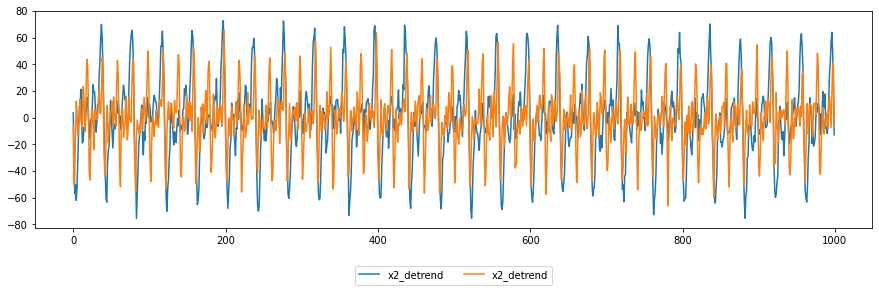

In [ ]:
#Gráfica de las series sin tendencia

x1_detrend = x1 - x1_trend
x2_detrend = x2 - x2_trend
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_detrend)), x1_detrend, label='x2_detrend')
plt.plot(range(len(x2_detrend)), x2_detrend, label='x2_detrend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [ ]:
#Estructura [x1 sin tendencia, x2 sin tendencia, índice de la observacion, etiqueta de la serie (1/0)]

x_lbl = np.column_stack([x1_detrend, x2_detrend, x_index, [1]*train_len+[0]*(len(x_index)-train_len)])
print(x_lbl.shape)
print(x_lbl)

(1000, 4)
[[  3.57171644  -6.19964947   0.           1.        ]
 [-29.07130256 -50.06297506   1.           1.        ]
 [-57.1245696  -41.14353152   2.           1.        ]
 ...
 [ 49.92306219  40.79447521 997.           0.        ]
 [ 25.59998584  37.9769494  998.           0.        ]
 [-12.80627598  -6.46303155 999.           0.        ]]


In [ ]:
x_train_max = x_lbl[x_lbl[:, 3]==1, :2].max(axis=0)
x_train_max = x_train_max.tolist()+[1]*2  # Sólo se normalizan las primeras 2 columnas
print(x_train_max) #Se agrega el [_,_,1,1] para despues al dividir, no hayan cambios en las últimas 2 coordenadas

[72.67309300236973, 65.67043568497644, 1, 1]


In [ ]:
x_normalize = np.divide(x_lbl, x_train_max) 
print(x_normalize)

[[ 4.91477147e-02 -9.44054871e-02  0.00000000e+00  1.00000000e+00]
 [-4.00028420e-01 -7.62336576e-01  1.00000000e+00  1.00000000e+00]
 [-7.86048415e-01 -6.26515282e-01  2.00000000e+00  1.00000000e+00]
 ...
 [ 6.86953866e-01  6.21200009e-01  9.97000000e+02  0.00000000e+00]
 [ 3.52262231e-01  5.78295987e-01  9.98000000e+02  0.00000000e+00]
 [-1.76217572e-01 -9.84161515e-02  9.99000000e+02  0.00000000e+00]]


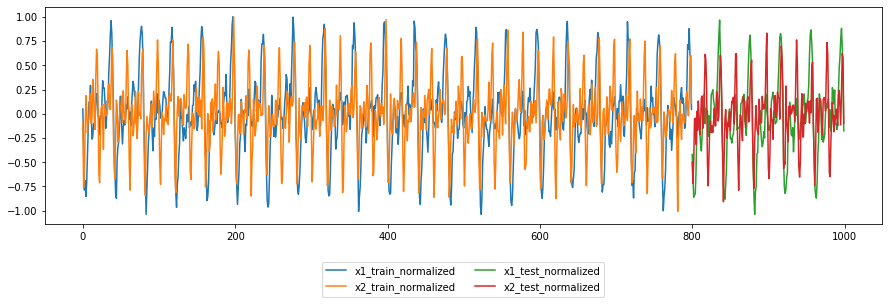

In [ ]:
#Data normalizada

#Train: primero 800 datos
#Test: últimos 200 datos

plt.figure(figsize=(15, 4))
plt.plot(range(train_len), x_normalize[:train_len, 0], label='x1_train_normalized')
plt.plot(range(train_len), x_normalize[:train_len, 1], label='x2_train_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 0], label='x1_test_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 1], label='x2_test_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [ ]:
def truncate(x, feature_cols=range(3), target_cols=range(3), label_col=3, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)
X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(3), target_cols=range(3), 
                            label_col=3, train_len=200, test_len=20)
print(X_in.shape, X_out.shape, lbl.shape)

(781, 200, 3) (781, 20, 3) (781,)


In [ ]:
#Dimensiones

X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

(600, 200, 3) (600, 20, 3)
(181, 200, 3) (181, 20, 3)


## Modelo Encoder-Decoder

In [ ]:
def encoder_decoder(n_hidden, X_input_train, X_output_train):

  input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
  output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

  #Encoder

  encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
  n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
  return_sequences=False, return_state=True)(input_train)

  #Batch Normalization

  encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
  encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

  #Decoder 

  decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
  decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])
  
  out = TimeDistributed(Dense(output_train.shape[2]))(decoder)

  #model

  model = Model(inputs=input_train, outputs=out)
  opt = Adam(lr=0.01, clipnorm=1)
  model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])

  return model

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


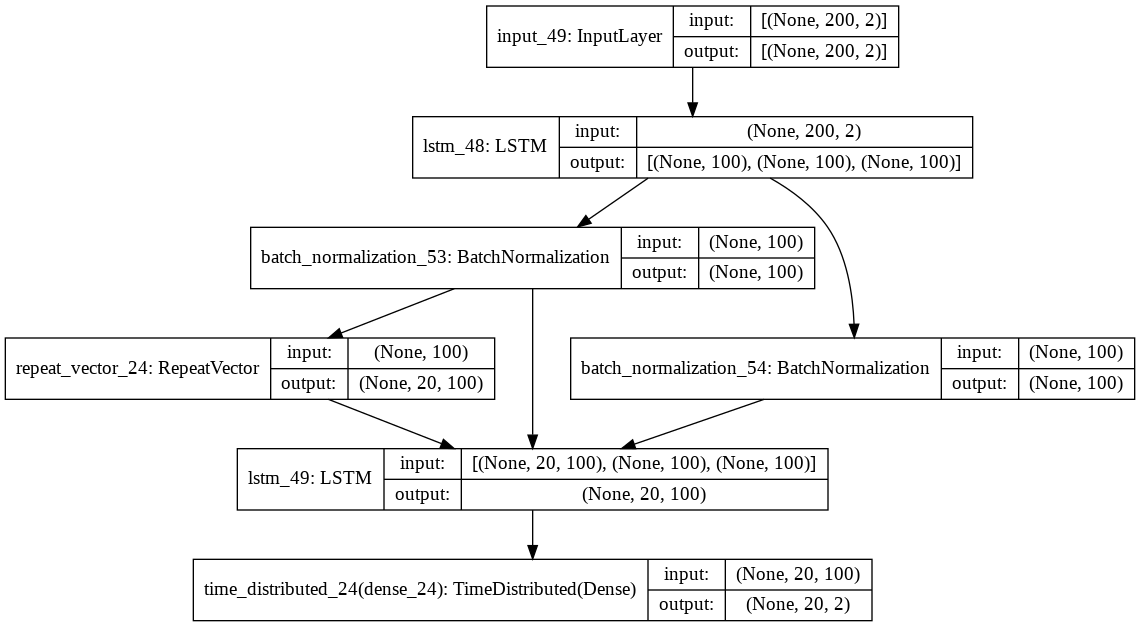

In [ ]:
model = encoder_decoder(100, X_input_train, X_output_train)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:

epc = 50
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                      epochs=epc, verbose=1, callbacks=[es], 
                      batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
  
model.save('model_forecasting_seq2seq.h5')

Epoch 1/50
5/5 [==============================] - 14s 1s/step - loss: 5.0958 - mae: 1.0445 - val_loss: 0.1274 - val_mae: 0.2580
Epoch 2/50
5/5 [==============================] - 3s 590ms/step - loss: 0.3048 - mae: 0.4170 - val_loss: 0.1370 - val_mae: 0.2704
Epoch 3/50
5/5 [==============================] - 3s 582ms/step - loss: 0.1390 - mae: 0.2807 - val_loss: 0.1232 - val_mae: 0.2611
Epoch 4/50
5/5 [==============================] - 3s 620ms/step - loss: 0.1303 - mae: 0.2685 - val_loss: 0.1103 - val_mae: 0.2423
Epoch 5/50
5/5 [==============================] - 3s 596ms/step - loss: 0.1222 - mae: 0.2587 - val_loss: 0.1044 - val_mae: 0.2350
Epoch 6/50
5/5 [==============================] - 3s 626ms/step - loss: 0.1152 - mae: 0.2502 - val_loss: 0.0994 - val_mae: 0.2308
Epoch 7/50
5/5 [==============================] - 3s 609ms/step - loss: 0.1102 - mae: 0.2451 - val_loss: 0.0899 - val_mae: 0.2220
Epoch 8/50
5/5 [==============================] - 3s 573ms/step - loss: 0.1055 - mae: 0.2420

In [ ]:
def predicciones(X_input_train, X_input_test):

  #comportamiento sin tendencia predicha
  train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
  test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]
  
  #comportamiento sin tendencia real
  train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
  test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]

  train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
  test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
  
  train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
  test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)

  #Se reconstruye la serie con su tendencia 

  data_final = dict()
  for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    
  #Se calculan los errores

  for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))

  return MAE_overall, MAE_

In [ ]:
epc = 50
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)
mae_list=[]
ventanas=[10, 15, 20, 25, 30]

for i in ventanas:

  #En cada paso se definen conjuntos con ventanas de largo 200 para predecir ventanas de largo [ventanas]
  X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(3), target_cols=range(3), 
                            label_col=3, train_len=200, test_len=i)
  
  X_input_train = X_in[np.where(lbl==1)]
  X_output_train = X_out[np.where(lbl==1)]
  X_input_test = X_in[np.where(lbl==0)]
  X_output_test = X_out[np.where(lbl==0)]

  model = encoder_decoder(100, X_input_train, X_output_train)
  history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                        epochs=epc, verbose=1, callbacks=[es], 
                        batch_size=32)
  train_mae = history.history['mae']
  valid_mae = history.history['val_mae']
    
  model.save('model_forecasting_seq2seq.h5')

  mae, _ = predicciones(X_input_train, X_input_test)
  mae_list.append(mae)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
15/15 [==============================] - 14s 439ms/step - loss: 1.4360 - mae: 0.7059 - val_loss: 0.1118 - val_mae: 0.2483
Epoch 2/50
15/15 [==============================] - 5s 303ms/step - loss: 0.1187 - mae: 0.2572 - val_loss: 0.0954 - val_mae: 0.2349
Epoch 3/50
15/15 [==============================] - 5s 305ms/step - loss: 0.1072 - mae: 0.2438 - val_loss: 0.0810 - val_mae: 0.2098
Epoch 4/50
15/15 [==============================] - 5s 308ms/step - loss: 0.0913 - mae: 0.2215 - val_loss: 0.0716 - val_mae: 0.1942
Epoch 5/50
15/15 [==============================] - 5s 305ms/step - loss: 0.0847 - mae: 0.2123 - val_loss: 0.0677 - val_mae: 0.1901
Epoch 6/50
15/15 [==============================] - 5s 303ms/step - loss: 0.0825 - mae: 0.2091 - val_loss: 0.0624 - val_mae: 0.1852
Epoch 7/50
15/15 [==============================] - 4s 299ms/step - loss: 0.0756 - mae: 0.2026 - val_loss: 0.0593 - val_mae: 0.1798
Epoch 8/50
15/15 [==============================] - 5s 304ms/step - loss: 0

In [ ]:
df_comparacion = pd.DataFrame(columns = ['enc dec mae', 'luong mae'])

df_comparacion['enc dec mae'] = mae_list

In [ ]:
df_comparacion

enc dec mae luong mae
0     6.391653       NaN
1     6.818788       NaN
2     6.994587       NaN
3     7.719536       NaN
4     6.586760       NaN

## Modelo con atención

In [ ]:
def luong_attention(n_hidden, X_input_train, X_output_train):
  
  input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
  output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

  #encoder
  encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_state=True, return_sequences=True)(input_train)

  #normalization
  encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
  encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

  #Decoder
  decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)

  decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
  return_state=False, return_sequences=True)(
  decoder_input, initial_state=[encoder_last_h, encoder_last_c])

  #Attention layer
  attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
  attention = Activation('softmax')(attention)
  
  #Vector de contexto
  context = dot([attention, encoder_stack_h], axes=[2,1])
  context = BatchNormalization(momentum=0.6)(context)

  decoder_combined_context = concatenate([context, decoder_stack_h])

  out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)

  #Model
  model = Model(inputs=input_train, outputs=out)
  opt = Adam(lr=0.01, clipnorm=1)
  model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])

  return model

In [ ]:
def predicciones_luong(X_input_train, X_input_test):

  model_luong = luong_attention(100, X_input_train, X_output_train)

  #comportamiento sin tendencia predicha
  train_pred_detrend = model_luong.predict(X_input_train[:, :, :2])*x_train_max[:2]
  test_pred_detrend = model_luong.predict(X_input_test[:, :, :2])*x_train_max[:2]
  
  #comportamiento sin tendencia real
  train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
  test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]

  train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
  test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
  
  train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
  test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)

  #Se reconstruye la serie con su tendencia 

  data_final = dict()
  for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    
  #Se calculan los errores

  for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))

  return MAE_overall, MAE_

In [ ]:
epc = 50
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)
mae_list_luong=[]
ventanas=[10, 15, 20, 25, 30]

for i in ventanas:

  #En cada paso se definen conjuntos con ventanas de largo 200 para predecir ventanas de largo [ventanas]
  X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(3), target_cols=range(3), 
                            label_col=3, train_len=200, test_len=i)
  
  X_input_train = X_in[np.where(lbl==1)]
  X_output_train = X_out[np.where(lbl==1)]
  X_input_test = X_in[np.where(lbl==0)]
  X_output_test = X_out[np.where(lbl==0)]

  model_luong = luong_attention(100, X_input_train, X_output_train)
  history = model_luong.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                        epochs=epc, verbose=1, callbacks=[es], 
                        batch_size=32)
  train_mae = history.history['mae']
  valid_mae = history.history['val_mae']
    
  model.save('model_forecasting_seq2seq.h5')

  mae, _ = predicciones_luong(X_input_train, X_input_test)
  mae_list_luong.append(mae)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
15/15 [==============================] - 15s 478ms/step - loss: 0.6417 - mae: 0.4591 - val_loss: 0.1146 - val_mae: 0.2602
Epoch 2/50
15/15 [==============================] - 5s 313ms/step - loss: 0.1115 - mae: 0.2496 - val_loss: 0.0880 - val_mae: 0.2207
Epoch 3/50
15/15 [==============================] - 5s 326ms/step - loss: 0.0976 - mae: 0.2323 - val_loss: 0.0753 - val_mae: 0.2038
Epoch 4/50
15/15 [==============================] - 5s 317ms/step - loss: 0.0896 - mae: 0.2207 - val_loss: 0.0731 - val_mae: 0.2084
Epoch 5/50
15/15 [==============================] - 5s 324ms/step - loss: 0.0723 - mae: 0.2003 - val_loss: 0.0643 - val_mae: 0.1931
Epoch 6/50
15/15 [==============================] - 5s 326ms/step - loss: 0.0708 - mae: 0.1979 - val_loss: 0.0503 - val_mae: 0.1690
Epoch 7/50
15/15 [==============================] - 5s 327ms/step - loss: 0.0571 - mae: 0.1805 - val_loss: 0.0392 - val_mae: 0.1527
Epoch 8/50
15/15 [==============================] - 5s 332ms/step - loss: 0

In [ ]:
df_comparacion['luong mae'] = mae_list_luong
df_comparacion.index = ventanas
df_comparacion

enc dec mae  luong mae
0     6.391653   6.820623
1     6.818788   6.381746
2     6.994587   6.374774
3     7.719536   6.439388
4     6.586760   6.707116

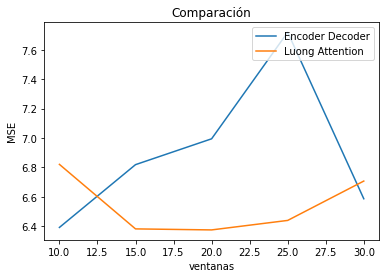

In [ ]:
plt.plot(df_comparacion['enc dec mae'], label='Encoder Decoder')
plt.plot(df_comparacion['luong mae'], label='Luong Attention')

plt.legend(loc='upper right')
plt.title('Comparación')
plt.ylabel('MSE')
plt.xlabel('ventanas')
plt.show()

# Conclusión

1) Los mecanismos atencionales funcionan en general mejor que los mecanismos encoder decoder.

2) Sin embargo, hay que considerar que el entrenamiento de los mecanismos atenciones virtualmente pueden ser más lentos de entrenar, pues bajo la técnica de early stopping este redes van mejorando más lentamente la optimización de la loss, obteniendo mejores resultado de generalización. Esto sucedio para la serie de la velocidad del viento ( la más complejas).